# cleaned_all_phones dataset (Using Sklearn and Keras)

##Importing Necessary Libraries

In [19]:
import math

# Data handling and stuff
import pandas as pd
import numpy as np
import tensorflow as tf

# Neural Network Magic Libraries (TensorFlow/Keras)
from tensorflow import keras
print('Tensorflow/Keras: %s' % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import Huber
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.layers import BatchNormalization
from keras import Input

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import classification_report
from sklearn.preprocessing import TargetEncoder

# Visualization - remove if not used
import matplotlib.pyplot as plt
# import seaborn as sns

Tensorflow/Keras: 3.8.0


##Visualization Formatting

In [20]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

## Data Acquisition and Preprocessing
##### Importing and Cleaning initial Dataset for Processing

In [21]:
def read_csv(file_path):
    df = pd.read_csv(file_path)
    return df

def clean_data(df):
    df = df.drop_duplicates()
    df = df.dropna()
    df = df.reset_index(drop=True)
    return df

In [22]:
# np.random.seed(42)

In [23]:
# smartphones = read_csv("CSVs Cleaned\Cleaned cleaned_all_phones.csv")
smartphones = read_csv("Cleaned cleaned_all_phones.csv")
cleaned_smartphones = clean_data(smartphones)
cleaned_smartphones.head()
cleaned_smartphones.info()

y = cleaned_smartphones["price"]
X = cleaned_smartphones.drop("price", axis=1)


categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    te = TargetEncoder(target_type="continuous", random_state=42, smooth = 'auto')
    data_array = X[col].values.reshape(-1, 1)
    X[col] = te.fit_transform(X[[col]], y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              1399 non-null   object 
 1   os                 1399 non-null   object 
 2   inches             1399 non-null   float64
 3   battery            1399 non-null   int64  
 4   battery_type       1399 non-null   object 
 5   ram(GB)            1399 non-null   int64  
 6   announcement_date  1399 non-null   object 
 7   weight(g)          1399 non-null   float64
 8   storage(GB)        1399 non-null   int64  
 9   video_720p         1399 non-null   bool   
 10  video_1080p        1399 non-null   bool   
 11  video_4K           1399 non-null   bool   
 12  video_8K           1399 non-null   bool   
 13  video_30fps        1399 non-null   bool   
 14  video_60fps        1399 non-null   bool   
 15  video_120fps       1399 non-null   bool   
 16  video_240fps       1399 

##Building our Feedforward Neural Network

##### Splitting training and testing samples

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Scaling our Data for Processing

In [25]:
# Scale Features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
# Scale Target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [26]:
def predict_price_with_margin(model, scaler, X_data):
    """Returns predictions with dollar margins"""
    scaled_pred = model.predict(X_data)
    pred_dollars = scaler.inverse_transform(scaled_pred).flatten()
    mae_dollars = mean_absolute_error(
        scaler.inverse_transform(y_test_scaled).flatten(),
        pred_dollars
    )
    return pred_dollars, mae_dollars


##### Defining the Structure of the Neural Network

In [27]:
model = Sequential(name="Smartphones_NN")
model.add(Input(shape=(X_train_scaled.shape[1],)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01))) # Input Layer
model.add(BatchNormalization())
model.add(Dropout(0.2)) # Deactivates 20% of neurons if they are not improving performance
model.add(Dense(32, activation='relu')) # Hidden Layer 1
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu')) # Hidden Layer 2
model.add(BatchNormalization())
model.add(Dense(1)) # Output Layer

##### Compile Keras model aka Magic

In [28]:
model.compile(
    optimizer=Adam(learning_rate=0.005),
    loss=Huber(delta=1.0),  # Handles Outliers better than mse
    metrics=['mae']
)

In [29]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train_scaled shape:", y_train_scaled.shape)

X_train_scaled shape: (979, 24)
y_train_scaled shape: (979, 1)


##### Fitting keras model onto the dataset

In [30]:
batch_size = 64
early_stop = EarlyStopping(monitor='val_mae', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_mae',
    factor=0.5,         # Reduce LR by 50%
    patience=5,         # Wait 5 epochs w/o improvement before reducing LR
    min_lr=1e-5,        # Smallest allowed LR
    verbose=1           # Print a message when LR changes
)
history = model.fit(X_train_scaled, y_train_scaled,
                    validation_data=(X_test_scaled, y_test_scaled),
                    epochs=200,
                    batch_size=batch_size,
                    verbose=1,
                    callbacks=[reduce_lr, early_stop])


# model.fit(X_train_scaled, y_train_scaled, batch_size=batch_size,steps_per_epoch=steps_per_epoch, epochs=10)

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.9130 - mae: 1.0261 - val_loss: 0.6933 - val_mae: 0.8197 - learning_rate: 0.0050
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.6470 - mae: 0.7541 - val_loss: 0.6537 - val_mae: 0.8031 - learning_rate: 0.0050
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5886 - mae: 0.7157 - val_loss: 0.5834 - val_mae: 0.7461 - learning_rate: 0.0050
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.5472 - mae: 0.6918 - val_loss: 0.5523 - val_mae: 0.7329 - learning_rate: 0.0050
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.5148 - mae: 0.6837 - val_loss: 0.5277 - val_mae: 0.7253 - learning_rate: 0.0050
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.5208 - mae: 0.7261 - val_loss: 0.5083 - val_mae: 0.7243 - learning_rate: 0.0050
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4715 - mae: 0.6809 - val_loss: 0.4839 - val_mae: 0.7094 - learning_rate: 0.0050
Epoch 

##### Making Predictions with our model

Evaluating model

In [31]:
# Get your scaled test predictions
y_pred_scaled = model.predict(X_test_scaled)

# Inverse transform BOTH predictions and true values
y_pred_dollars = scaler_y.inverse_transform(y_pred_scaled).flatten()
y_true_dollars = scaler_y.inverse_transform(y_test_scaled).flatten()

# Calculate MAE in original dollars
test_loss, test_mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"Test MAE: {test_mae:.4f}")
mae_dollars = mean_absolute_error(y_true_dollars, y_pred_dollars)

print(f"Official Test MAE (USD): ±${mae_dollars:.2f}")
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_true_dollars, y_pred_dollars):.2f}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Test MAE: 0.6835
Official Test MAE (USD): ±$95.57
Mean Absolute Percentage Error: 0.36


Bias Check

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Text(0.5, 1.0, 'Error Distribution')

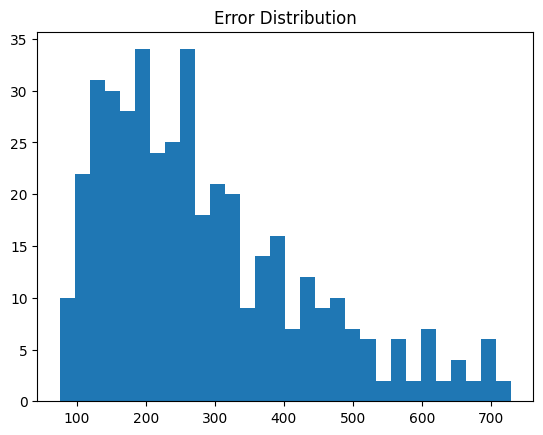

In [32]:
predictions = model.predict(X_test_scaled)
errors = y_test - predictions.flatten()
plt.hist(errors, bins=30)
plt.title("Error Distribution")

In [33]:
# Make predictions and compare with true values
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


##Plots

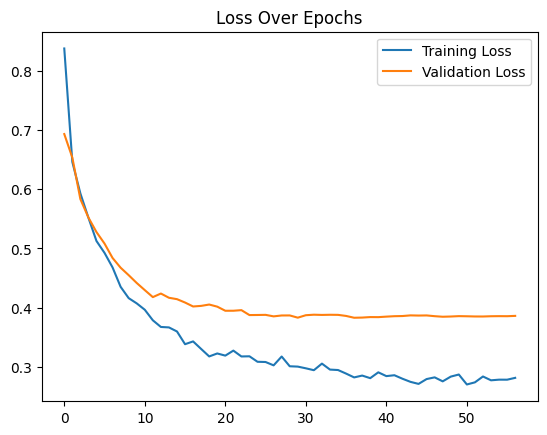

In [34]:
# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()



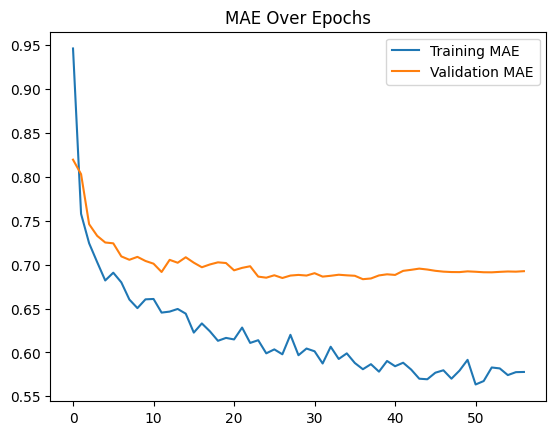

In [35]:
# Plot MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.legend()
plt.show()

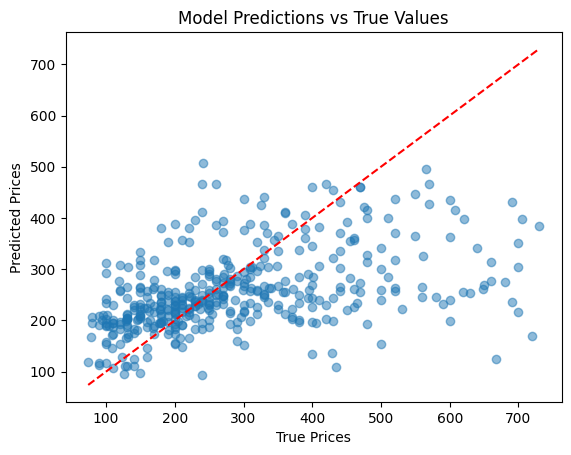

In [36]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("True Prices")
plt.ylabel("Predicted Prices")
plt.title("Model Predictions vs True Values")
plt.show()